In [27]:
# Imports
import torch as th
import numpy as np
import math

import matplotlib.pyplot as plt
import random


In [3]:
def set_seed(seed = 1234):
    """_summary_
    Sets the seed of the entire notebook so results are the same every time we run.
    This is for reproducilibilty.

    Args:
        seed (int, optional): _description_. Defaults to 1234.
    """

    # Set the random seed manually for reproducibility.
    np.random.seed(seed)
    random.seed(seed)
    th.manual_seed(seed)
    th.cuda.manual_seed(seed)

    # When running on the CuDNN backend, two further options must be set
    th.backends.cudnn.deterministic = True


set_seed()

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(f"Avaliable device is {device}")


Avaliable device is cpu


#### Create Datasets

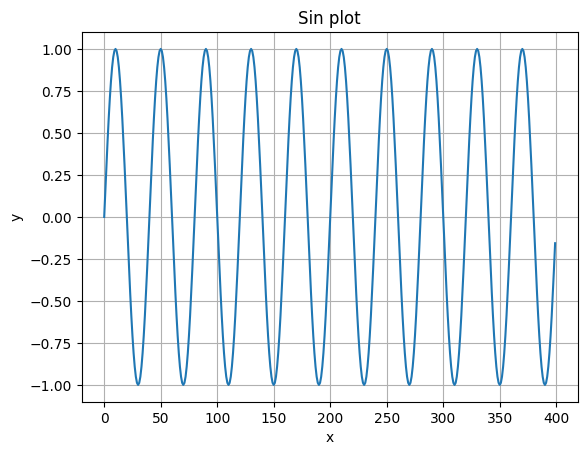

In [39]:
start_point= 0
end_point = 399

x = th.linspace(start=start_point,end=end_point, steps=end_point-start_point+1)
y = th.sin((x*2*math.pi)/40)

# plot x and y with matplotlib
plt.Figure(figsize=(2, 20))
plt.title("Sin plot")
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.plot(x,y)
plt.show()



#### Batching the Data

In [40]:
test_size = 40
train_set = y[:-test_size]
test_set = y[-test_size:]

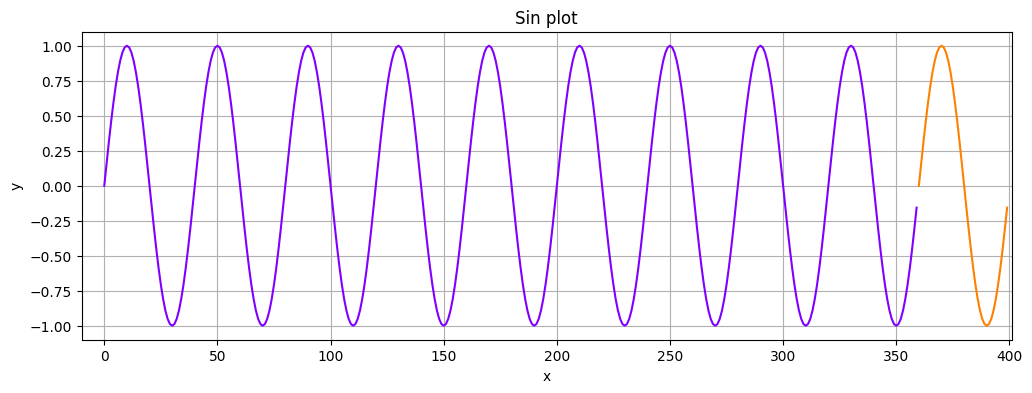

In [44]:
plt.figure(figsize=(12,4))
plt.xlim(-10,401)
plt.grid(True)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Sin plot")
plt.plot(train_set.numpy(),color='#8000ff')
plt.plot(range(360,400),test_set.numpy(),color="#ff8000")
plt.show()

#### Creating the batches of data

In [45]:
def input_data(seq,ws):
    out = []
    L = len(seq)
    
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    
    return out

In [46]:
window_size = 20
train_data = input_data(train_set, window_size)
len(train_data)

340

#### Defining the Model

In [48]:
class VanillaLSTM(th.nn.Module):
    
    def __init__(self, input_size = 1, hidden_size = 50, out_size = 1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = th.nn.LSTM(input_size, hidden_size)
        self.linear = th.nn.Linear(hidden_size,out_size)
        self.hidden = (th.zeros(1,1,hidden_size),th.zeros(1,1,hidden_size))
    
    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]

In [54]:
lstm_model = VanillaLSTM()
criterion = nn.MSELoss()
optimizer = th.optim.SGD(lstm_model.parameters(), lr=0.01)

Epoch 0 Loss: 5.9945989050902426e-05
Performance on test range: 0.0022273478098213673


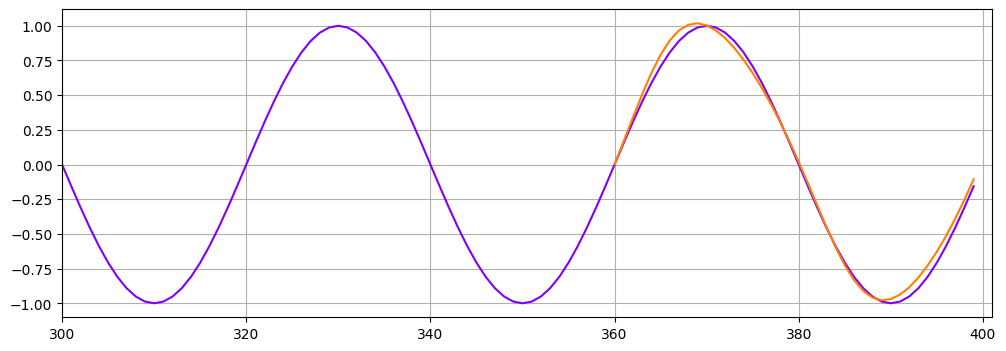

Epoch 1 Loss: 5.790519207948819e-05
Performance on test range: 0.0022320509888231754


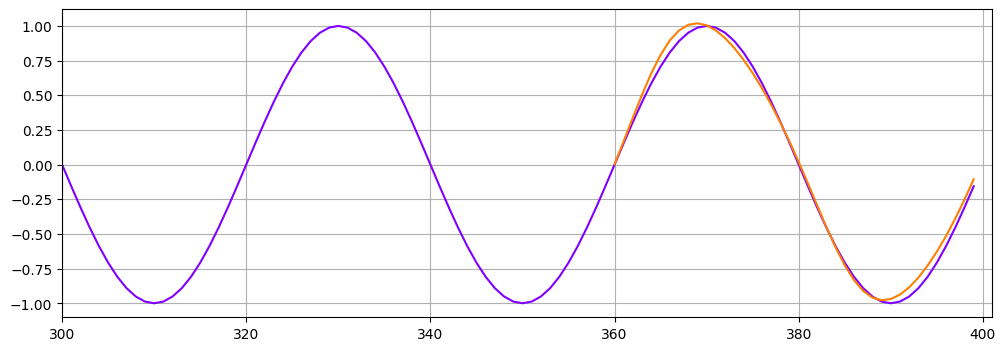

Epoch 2 Loss: 5.6008531828410923e-05
Performance on test range: 0.002237227512523532


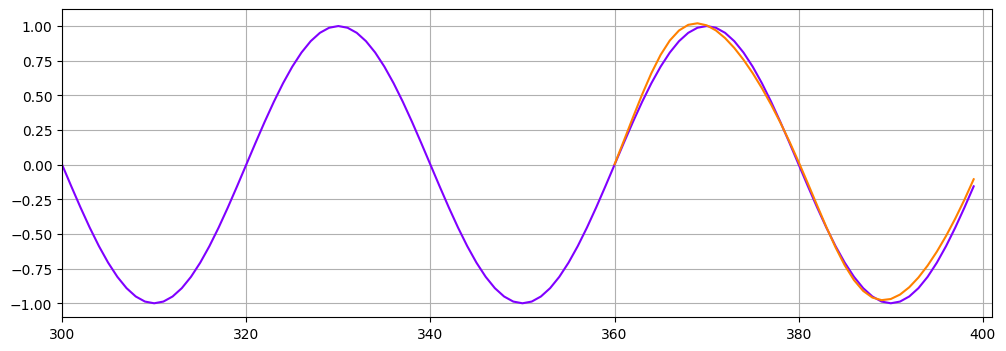

Epoch 3 Loss: 5.423383481684141e-05
Performance on test range: 0.0022419195156544447


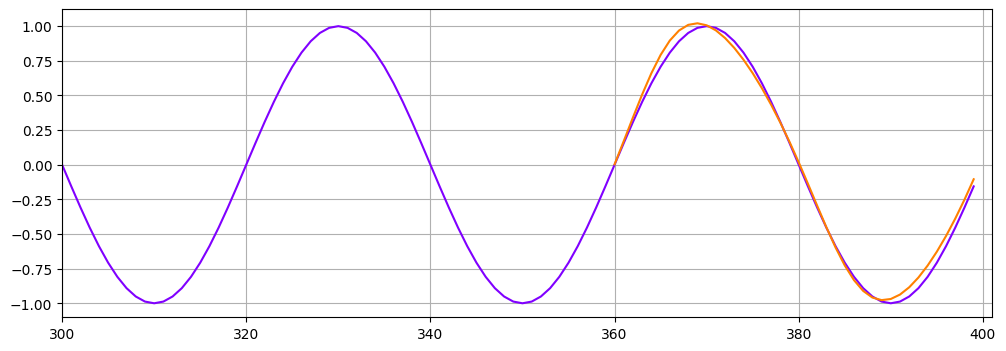

Epoch 4 Loss: 5.2568277169484645e-05
Performance on test range: 0.002246095798909664


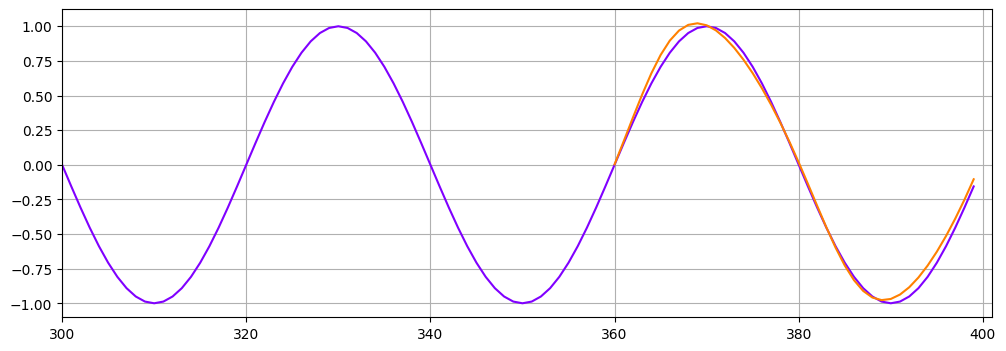

Epoch 5 Loss: 5.100082125863992e-05
Performance on test range: 0.0022497009485960007


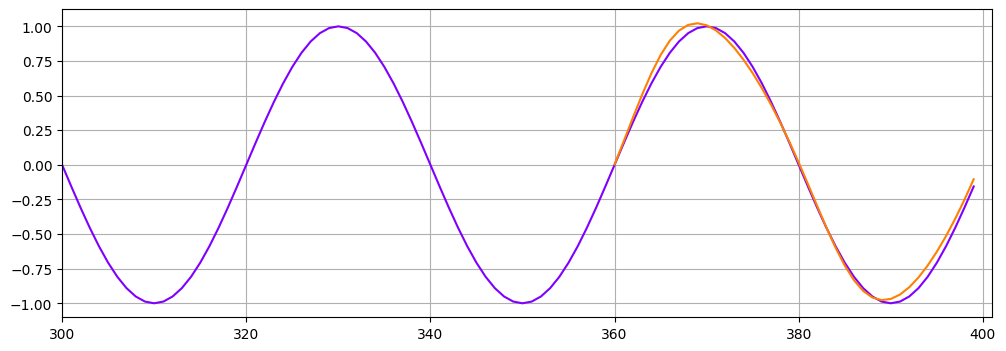

Epoch 6 Loss: 4.951893424731679e-05
Performance on test range: 0.002252505859360099


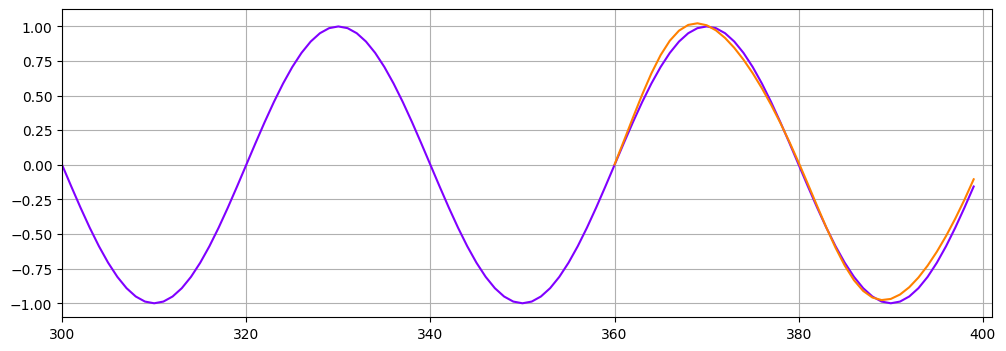

Epoch 7 Loss: 4.811800317838788e-05
Performance on test range: 0.0022547361440956593


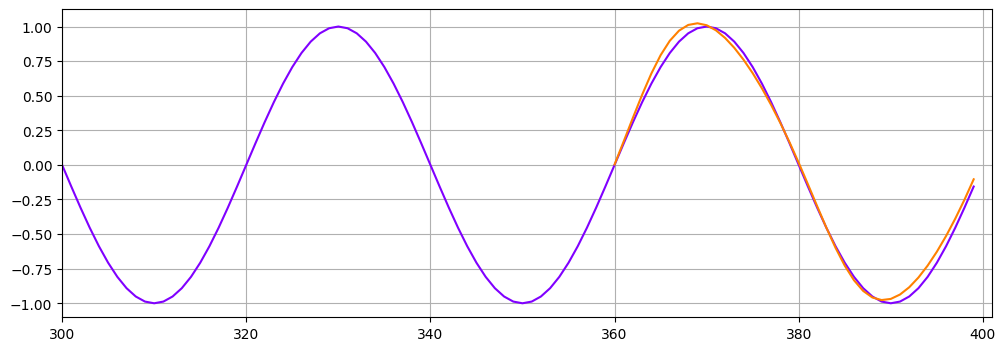

Epoch 8 Loss: 4.679077028413303e-05
Performance on test range: 0.00225631520152092


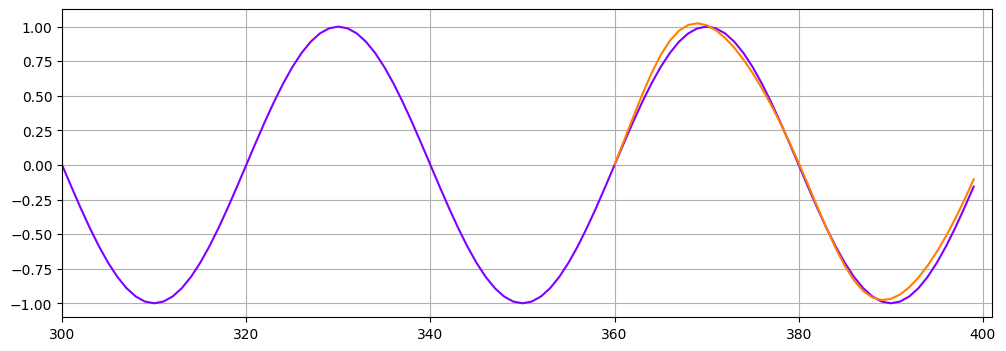

Epoch 9 Loss: 4.552934842649847e-05
Performance on test range: 0.002257126849144697


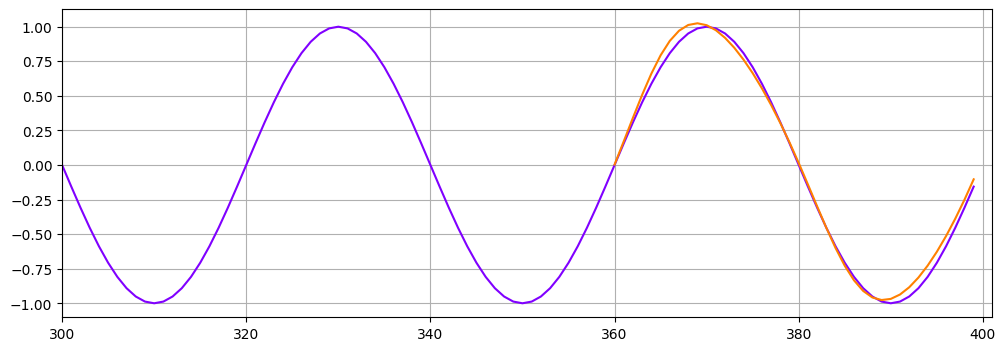

Epoch 10 Loss: 4.4329794036457315e-05
Performance on test range: 0.002257403451949358


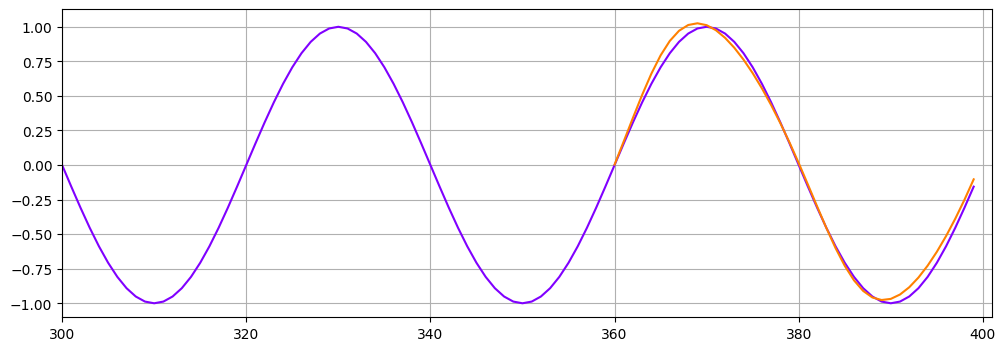

Epoch 11 Loss: 4.31877670052927e-05
Performance on test range: 0.0022569880820810795


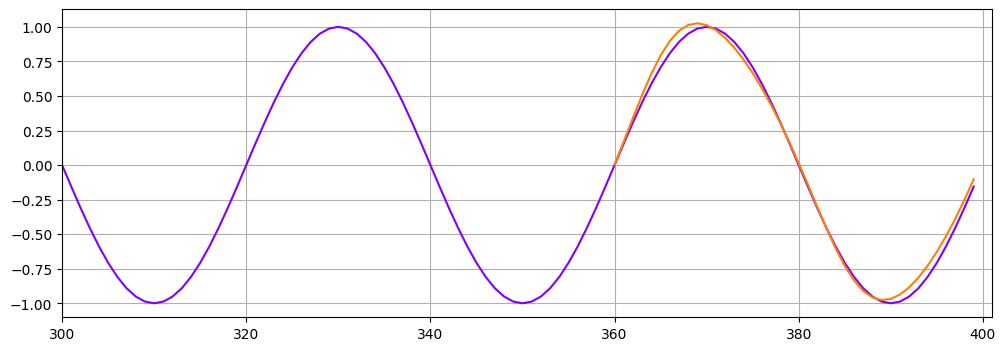

Epoch 12 Loss: 4.209389226161875e-05
Performance on test range: 0.002255805302411318


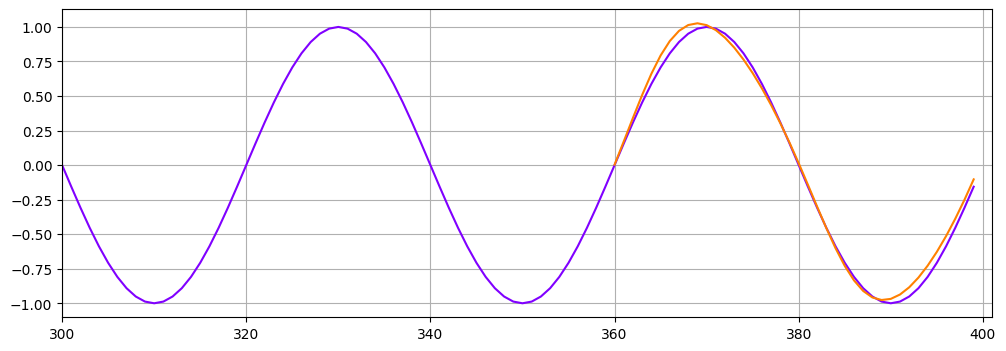

Epoch 13 Loss: 4.10507018386852e-05
Performance on test range: 0.0022540311329066753


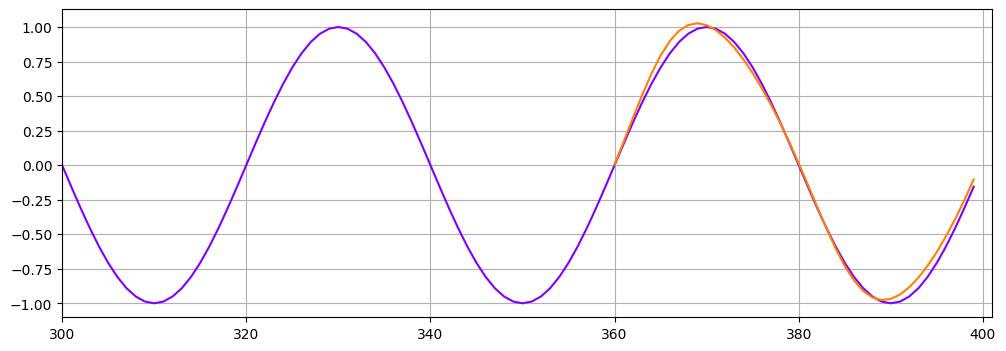

Epoch 14 Loss: 4.005039227195084e-05
Performance on test range: 0.002251633908599615


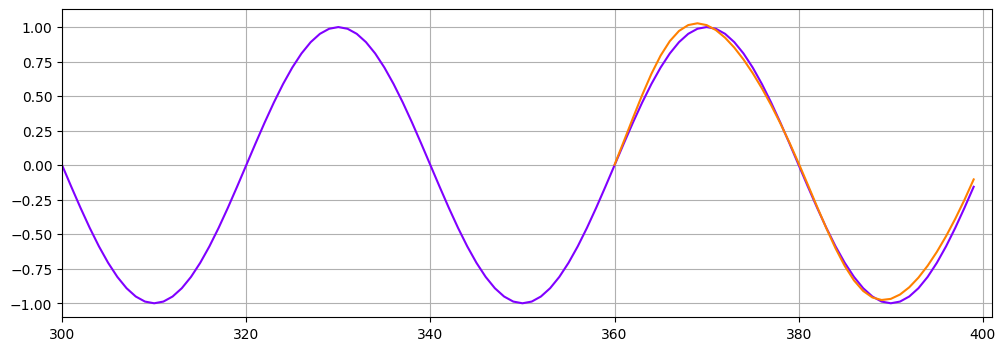

Epoch 15 Loss: 3.909167571691796e-05
Performance on test range: 0.0022486441303044558


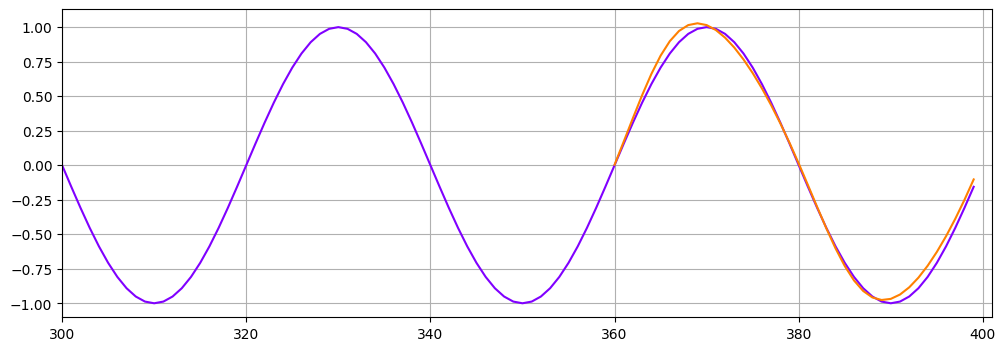

Epoch 16 Loss: 3.8171445339685306e-05
Performance on test range: 0.0022452203556895256


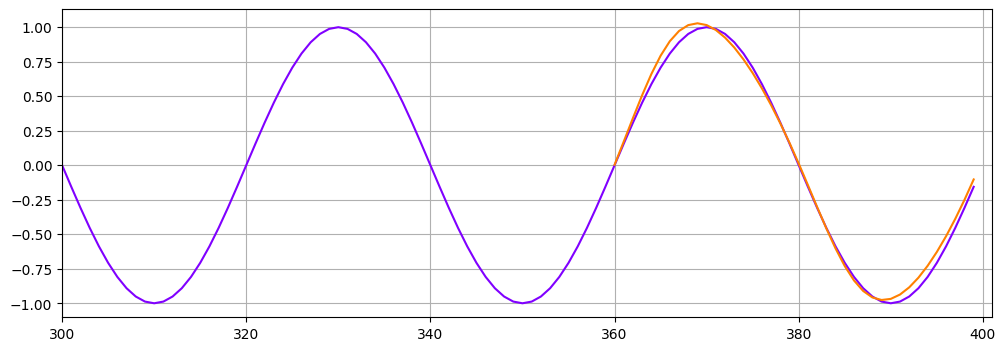

Epoch 17 Loss: 3.7286197766661644e-05
Performance on test range: 0.0022411008831113577


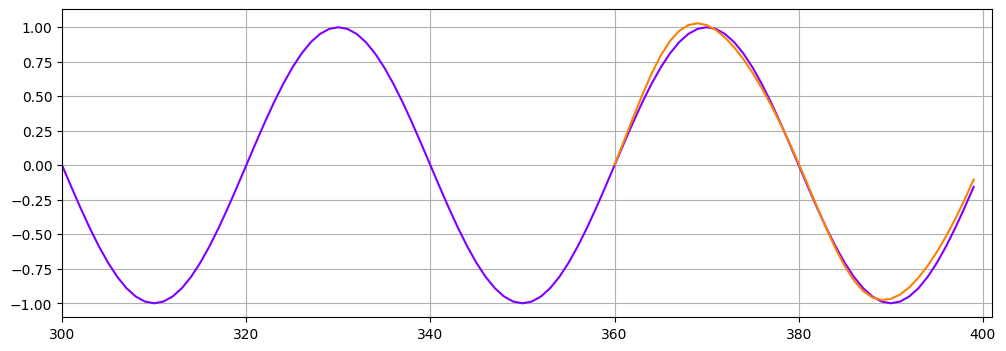

Epoch 18 Loss: 3.6435434594750404e-05
Performance on test range: 0.002236750675365329


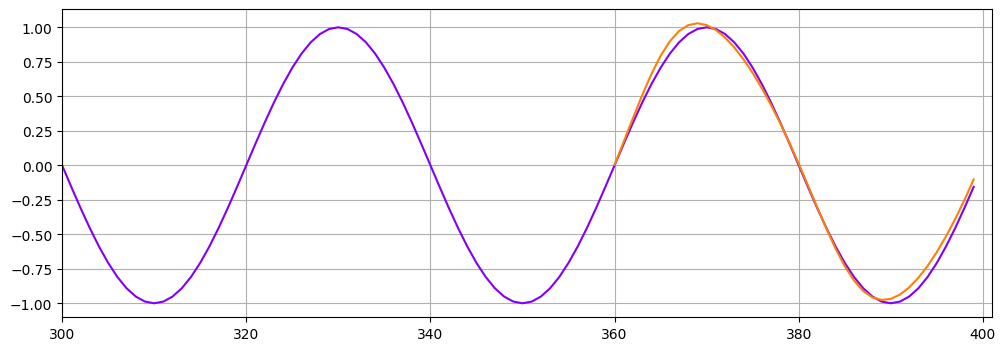

Epoch 19 Loss: 3.561440826160833e-05
Performance on test range: 0.0022316027898341417


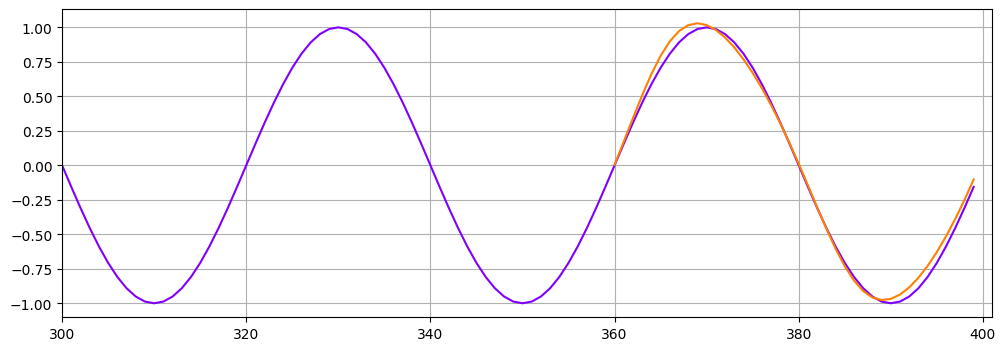

In [56]:
epochs = 20
future = 40

for i in range(epochs):
    
    for seq, y_train in train_data:
        optimizer.zero_grad()
        lstm_model.hidden = (th.zeros(1,1,lstm_model.hidden_size), th.zeros(1,1,lstm_model.hidden_size))
        
        y_pred = lstm_model(seq)
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {i} Loss: {loss.item()}")
    
    preds = train_set[-window_size:].tolist()
    for f in range(future):
        seq = th.FloatTensor(preds[-window_size:])
        with th.no_grad():
            lstm_model.hidden = (th.zeros(1,1,lstm_model.hidden_size),th.zeros(1,1,lstm_model.hidden_size))
            preds.append(lstm_model(seq).item())
        
    loss = criterion(th.tensor(preds[-window_size:]), y[-window_size:])
    print(f"Performance on test range: {loss}")
    
    plt.figure(figsize=(12,4))
    plt.xlim(300,401)
    plt.grid(True)
    plt.plot(y.numpy(),color='#8000ff')
    plt.plot(range(360,400), preds[window_size:], color='#ff8000')
    plt.show()